## Labolatorium 13
### Minializacja funkcji

---
### Przydatne importy

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [14, 7]

---
### Zadanie 1 - Problem komiwojażera

Wygeneruj chmurę $n$ losowych punktow w 2D, a nastepnie zastosuj algorytm symulowanego wyżarzania do przybliżonego rozwiązania problemu komiwojażera dla tych punktów.

Poniżej stworzę klasę `Graph`, która będzie reprezentacją grafu w problemie komiwojażera. Dodam do niej również ,metody plotujące aktualnie najlepszą ścieżkę oraz sam graf wraz z początkową ścieżką.

In [192]:
class Graph:
    def __init__(self, points):
        self.points = np.array(points)
        self.best_points = self.points.copy()
        
    
    def get_distance(self, points):
        n = points.shape[0]
        paths = np.array([np.linalg.norm(points[i] - points[i-1]) for i in range(n-1, -1, -1)])
        return np.sum(paths)
    
    
    def plot(self, points, title):
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        fig.suptitle(title)
    
        ax1.set_title(f'Oryginalny graf')
        ax2.set_title(f'Dlugosc sciezki = {self.get_distance(points)}')
        ax1.scatter(points[:,0], points[:,1])
        ax2.scatter(points[:,0], points[:,1])

        points_lines = np.concatenate((points, points[0].reshape(1, 2)))
        ax2.plot(points_lines[:,0], points_lines[:,1])
              
        plt.show()
        
    
    
    def plot_graph(self, title="Stan poczatkowy"):
        self.plot(self.points, title)
                
    
    def plot_best_path(self, title="Najlepsza sciezka"):
        self.plot(self.best_points, title)
    
    
    def swap(self, prev_perm, kind="arbitrary_swap"):
        n = self.best_points.shape[0]
        next_perm = prev_perm.copy()
        
        if kind == "arbitrary_swap":
            [i, j] = np.random.randint(n, size=2)
            next_perm[[i, j]] = next_perm[[j, i]]
        else:
            index = np.random.randint(n)
            next_perm[[index, (index + 1) % n]] = next_perm[[(index + 1) % n, index]]
        
        return next_perm
    
    
    def prob_f(self, delta_c, temp):
        return np.exp(-delta_c / temp) if delta_c > 0.0 else 1.0
        
    
    def temp_f(self, temp, cool_rate):
        return (1.0 - cool_rate) * temp

    

    def dual_annealing(self, temperature, cool_rate, swap_kind="arbitrary_swap"):
        cur_state = self.points.copy()
        best_dist = self.get_distance(self.best_points)
        
        eps = 10**(-6)
        
        while temperature > eps:
            next_state = self.swap(cur_state, kind=swap_kind)
            
            
            next_dist = self.get_distance(next_state)
            cur_dist = self.get_distance(cur_state)
            
            if self.prob_f(next_dist - cur_dist, temperature) > np.random.uniform():
                cur_state = next_state
            
            if next_dist < best_dist:
                self.best_points = next_state
                best_dist = next_dist
            
            temperature = self.temp_f(temperature, cool_rate)
        
        return self.best_points

W powyższej implementacji metoda `dual_annealing` jest realizacją symulowanego wyżarzania. Jako parametry przyjmuje:
* początkową temperaturę `temperature`
* stałą wygaszania `cool_rate` używaną w funkcji wygaszania temperatury
* rodzaj sposobu generacji sąsiedniego stanu `swap_kind` (domyślnie *arbitrary_swap*) - więcej o tym w następnych podpunktach

---
a) Przedstaw wizualizację otrzymanego rozwiązania dla 3 różnych wartości n oraz 3 różnych układów punktów w 2D (rozkład jednostajny, rozkład normalny z czterema różnymi grupami parametrów, dziewięć odseparowanych grup punktów).

Niech $n \in \{50, 200, 500\}$

#### Rozkład jednostajny

In [193]:
def uniform_test(n):
    points = np.random.uniform(0, 100, size=(n, 2))
    G = Graph(points)
    G.plot_graph(f"Rozklad jednostajny, n={n} - Stan poczatkowy")
    G.dual_annealing(1000, 0.005)
    G.plot_best_path(f"Rozklad jednostajny, n={n} - Najlepsza sciezka")

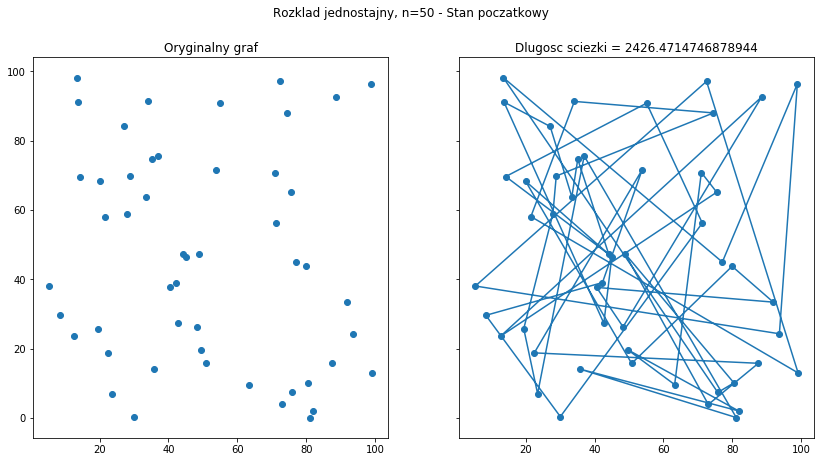

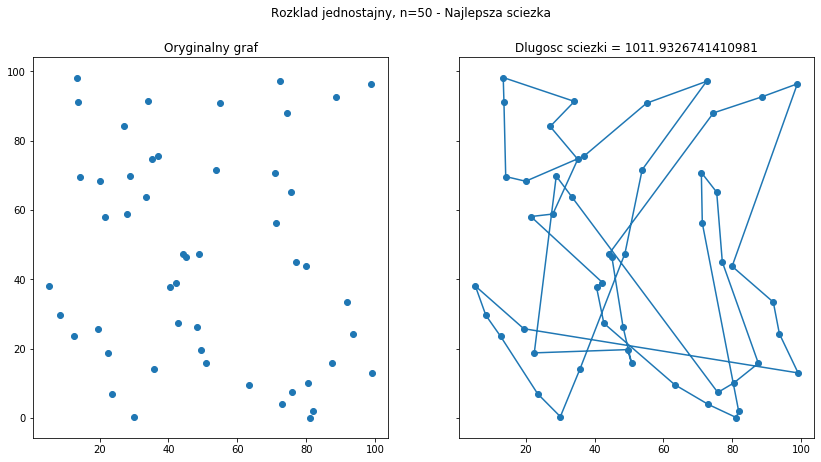

In [194]:
uniform_test(50)

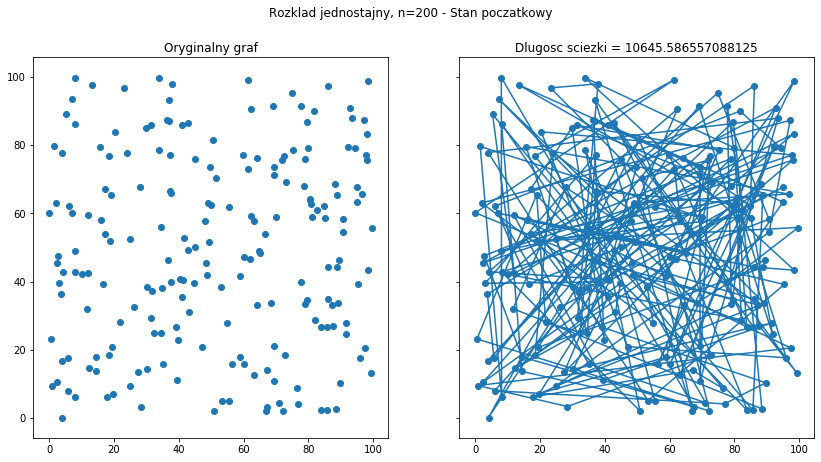

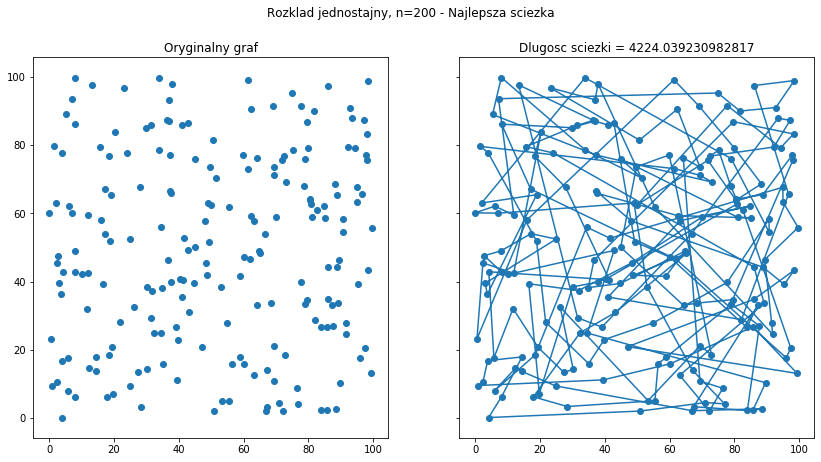

In [195]:
uniform_test(200)

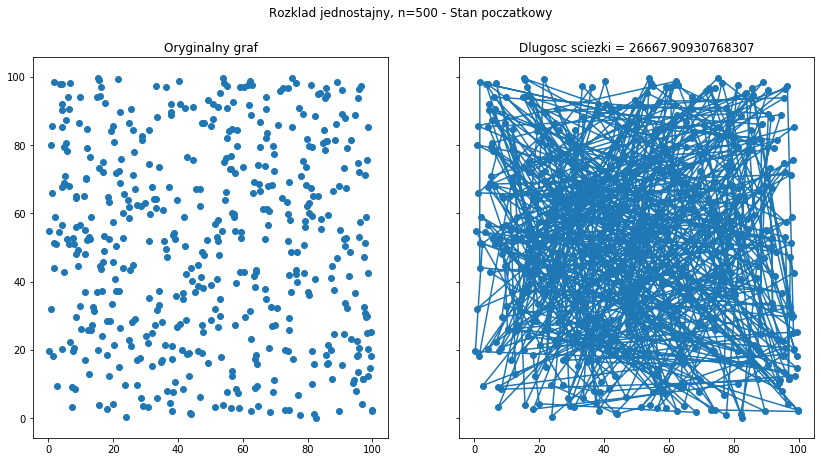

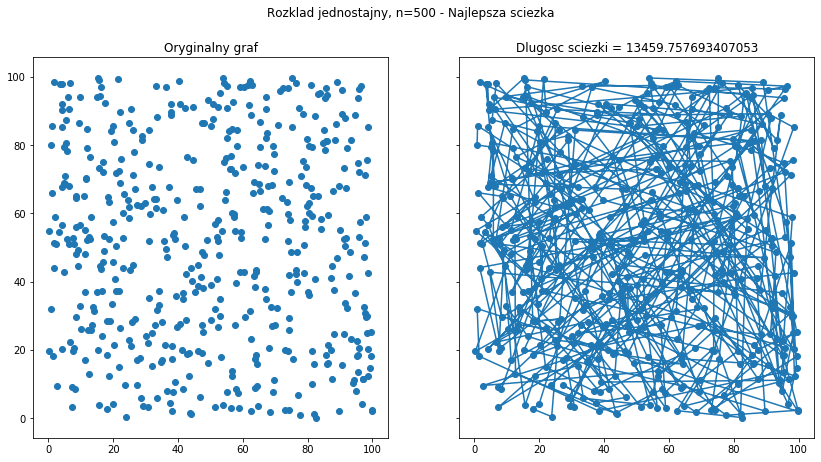

In [196]:
uniform_test(500)

Jak widać dzięki optymalizacji przy użyciu symulowanego wyżarzania udało się uzyskać ścieżki średnio ponad dwa razy krótsze a to wszystko w nie najdłuższym czasie.

#### Rozkład normalny z czterema różnymi grupami parametrów

Niech $\mu \in \{ 0, -10, 10, 5 \} $ oraz $\sigma \in \{1, 5, 2, 10\}$

In [199]:
def normal_test(n):
    mu = [0, -10, 10, 5]
    sigma = [1, 15, 5, 10]
    groups = np.array([np.random.normal(mu[i], sigma[i], size=(n//4, 2)) for i in range(4)])
    
    points = groups.reshape((-1, 2))

    G = Graph(points)
    G.plot_graph(f"Rozklad normalny, n={n} - Stan poczatkowy")
    G.dual_annealing(1000, 0.005)
    G.plot_best_path(f"Rozklad normalny, n={n} - Najlepsza sciezka")

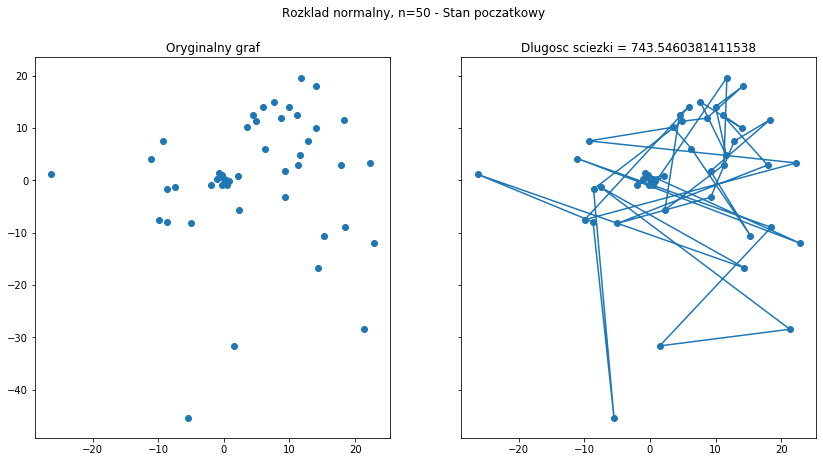

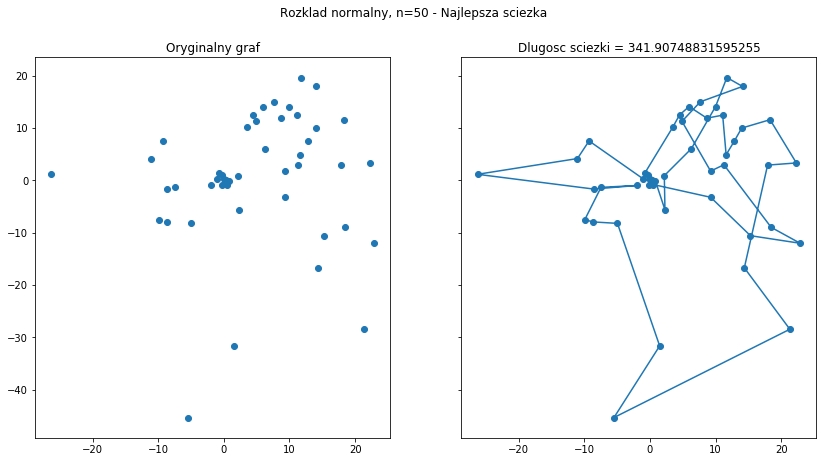

In [200]:
normal_test(50)

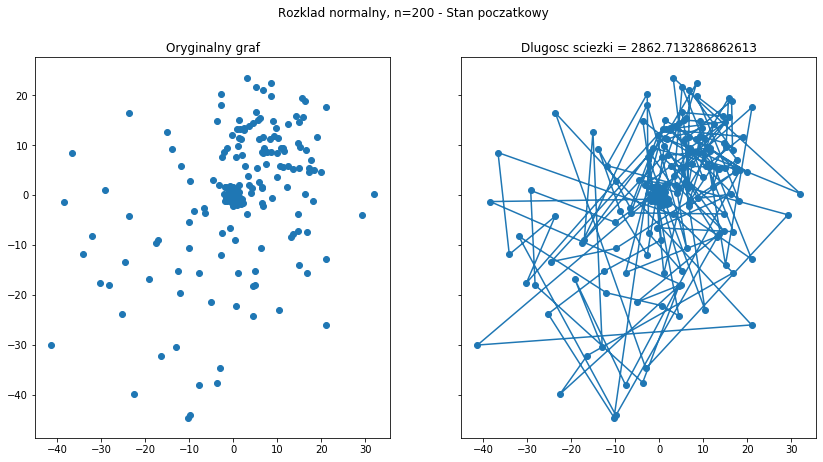

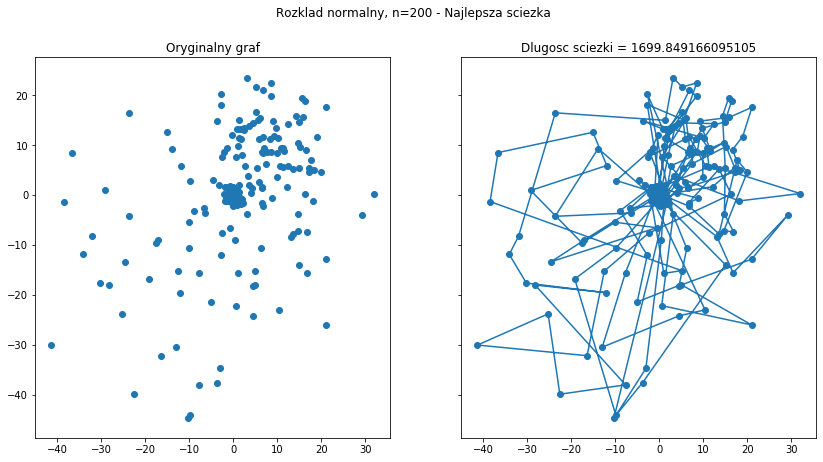

In [201]:
normal_test(200)

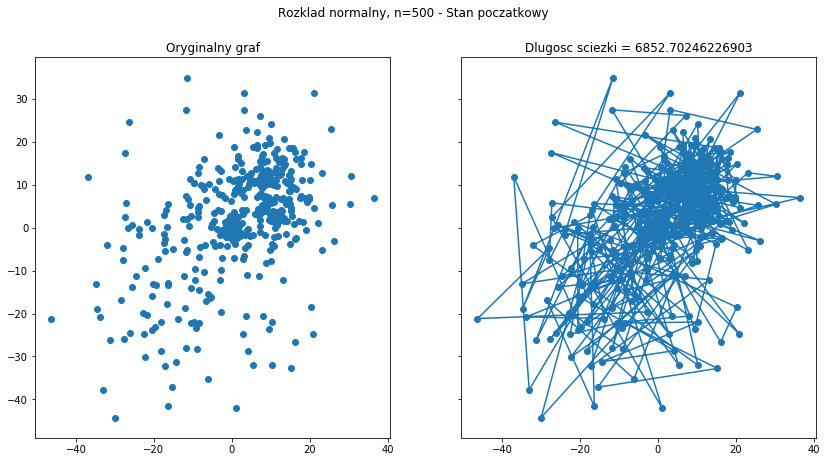

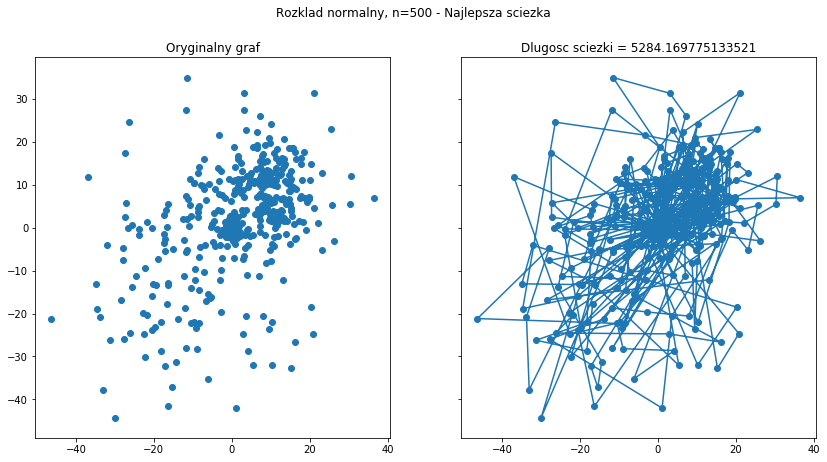

In [202]:
normal_test(500)

W przypadku rozkładu normalnego również widzimy poprawę wyniku dzięki symulowanemu wyżarzaniu. Nie jest jednak ona aż tak znacząca, ponieważ początkowa ścieżka, która najpierw łączy wszystkie punkty z rozkładu o tych samych parametrach jest już dość dobrym stanem początkowym - te punkty zazwyczaj są dość bliskie sobie i całkiem dobrym wyborem jest odwiedzenie najpierw całej takiej grupy, a następnie przejście do kolejnej.

#### Dziewięć odseparowanych grup punktów

In [240]:
def nine_groups_test(n):
    mu = [0, 10, 20]
    x = np.array([np.random.normal(mu[i%3], 1, size = n//9) for i in range(9)]).reshape(-1, 1)
    
    y = np.array([np.random.normal(mu[i//3], 1, size = n//9) for i in range(9)]).reshape(-1, 1)
    
    
    points = np.concatenate((x, y), axis=1)
    
    np.random.shuffle(points)

    G = Graph(points)
    G.plot_graph(f"Dziewiec odseparowanych grup, n={n} - Stan poczatkowy")
    G.dual_annealing(1000, 0.005)
    G.plot_best_path(f"Dziewiec odseparowanych grup, n={n} - Najlepsza sciezka")

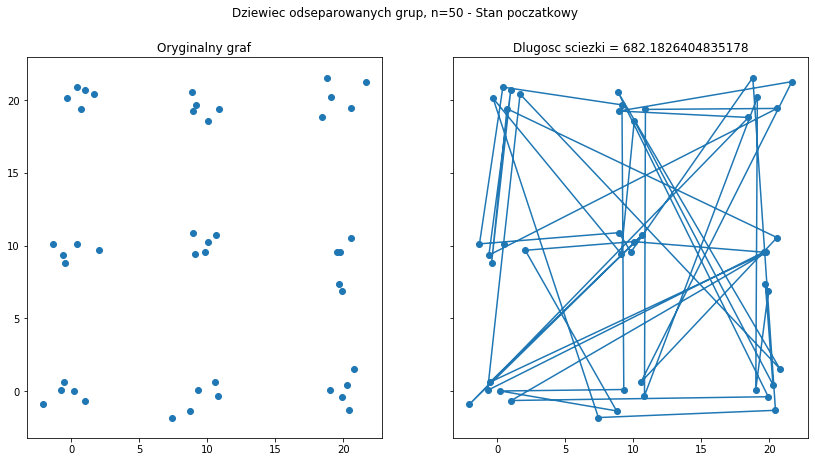

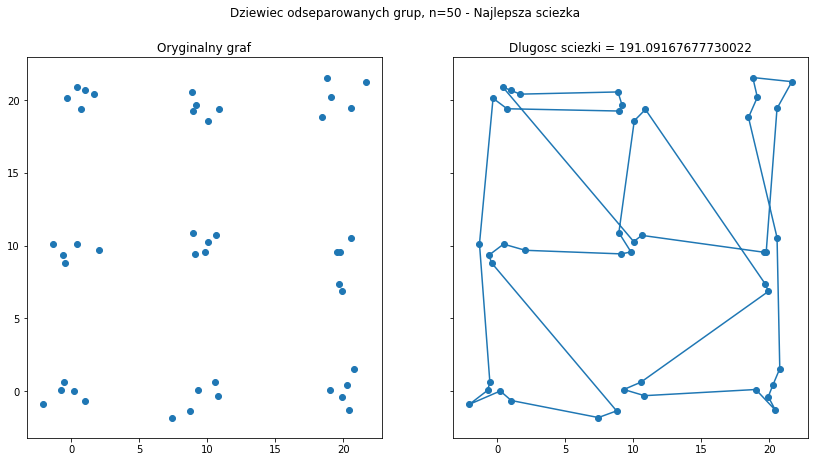

In [241]:
nine_groups_test(50)

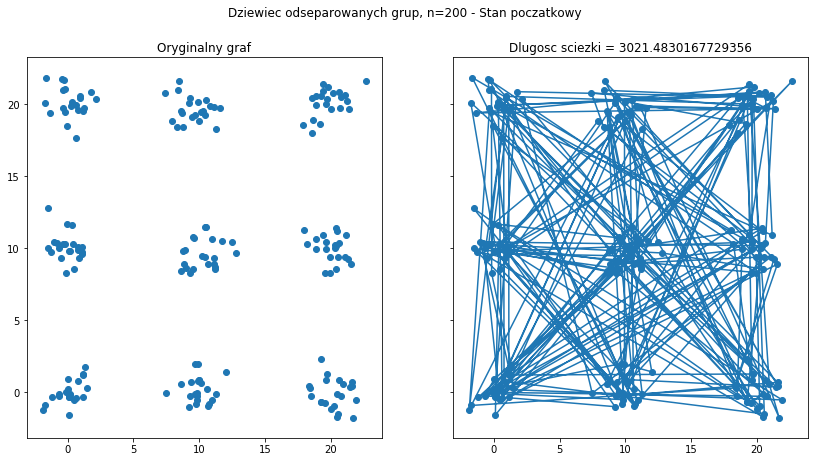

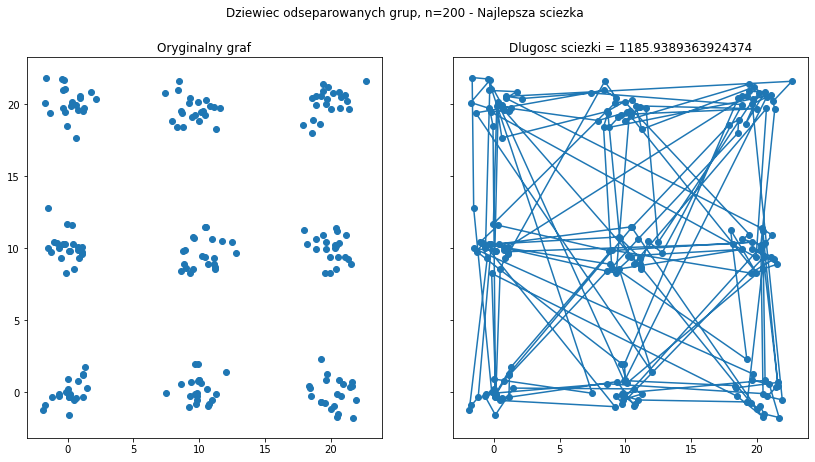

In [242]:
nine_groups_test(200)

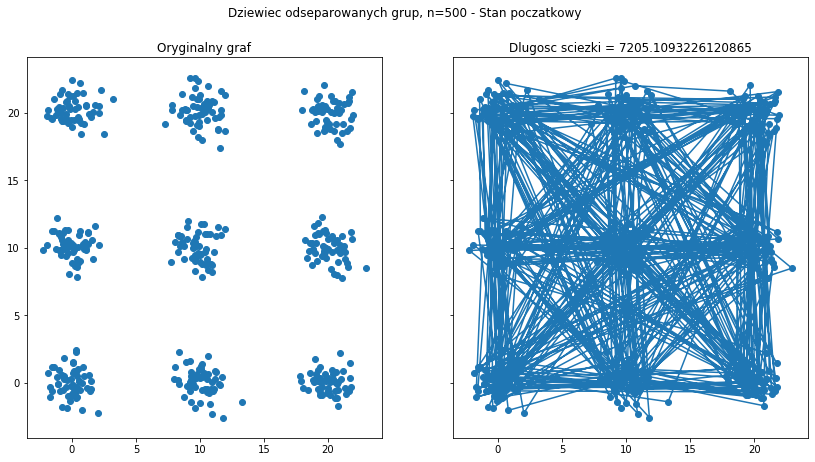

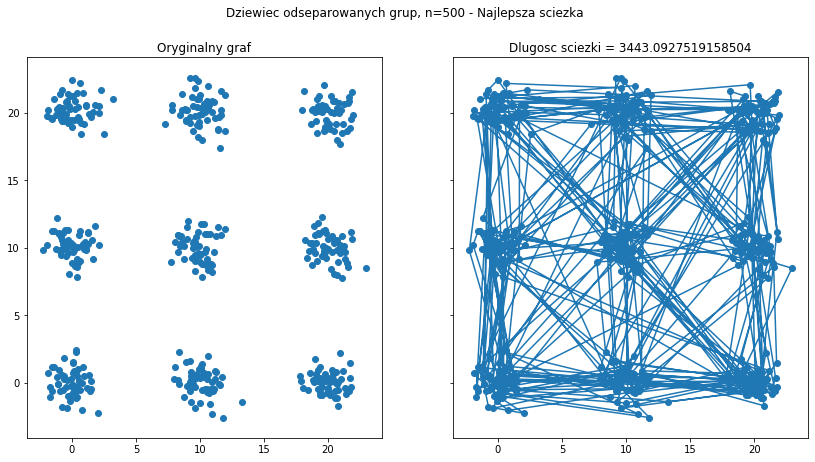

In [243]:
nine_groups_test(500)

Ponownie widzimy zoptymalizowaną długość ścieżki - ten przykład jednak pokazuje nam, że znalezione rozwiązanie z pewnością nie jest idealne, a jedynie przybliżone.

---
b) Zbadaj wpływ sposobu generacji sąsiedniego stanu (consecutive swap - zamiana kolejności losowej pary połączonych wierzchołków w ścieżce vs. arbitrary swap - zamiana dwóch losowych wierzchołków w ścieżce) oraz początkowej wartości temperatury na zbieżność procesu optymalizacji.

W poprzednim zadaniu stale używaliśmy temperatury $T = 1000$, stałej wyżarzania $\alpha = 0,005$ oraz typu permutacji *arbitrary swap*. Teraz sprawdzimy jak zmiana tych parametrów wpływa na rozwiązanie końcowe.

Dla testów *arbitrary swap* vs *consecutive swap* będą wszystkie 3 rozkłady dla $n = 200$.

In [244]:
n = 200
points = np.random.uniform(0, 100, size=(n, 2))
arbitrary = []
consecutive = []

G = Graph(points)
G.dual_annealing(1000, 0.005, swap_kind='arbitrary_swap')
arbitrary.append(G.get_distance(G.best_points))
G.best_points = points
G.dual_annealing(1000, 0.005, swap_kind='consecutive_swap')
consecutive.append(G.get_distance(G.best_points))

In [245]:
mu = [0, -10, 10, 5]
sigma = [1, 15, 5, 10]
groups = np.array([np.random.normal(mu[i], sigma[i], size=(n//4, 2)) for i in range(4)])

points = groups.reshape((-1, 2))

G = Graph(points)
G.dual_annealing(1000, 0.005, swap_kind='arbitrary_swap')
arbitrary.append(G.get_distance(G.best_points))
G.best_points = points
G.dual_annealing(1000, 0.005, swap_kind='consecutive_swap')
consecutive.append(G.get_distance(G.best_points))

In [246]:
mu = [0, 10, 20]
x = np.array([np.random.normal(mu[i%3], 1, size = n//9) for i in range(9)]).reshape(-1, 1)

y = np.array([np.random.normal(mu[i//3], 1, size = n//9) for i in range(9)]).reshape(-1, 1)


points = np.concatenate((x, y), axis=1)

np.random.shuffle(points)

G = Graph(points)
G.dual_annealing(1000, 0.005, swap_kind='arbitrary_swap')
arbitrary.append(G.get_distance(G.best_points))
G.best_points = points
G.dual_annealing(1000, 0.005, swap_kind='consecutive_swap')
consecutive.append(G.get_distance(G.best_points))

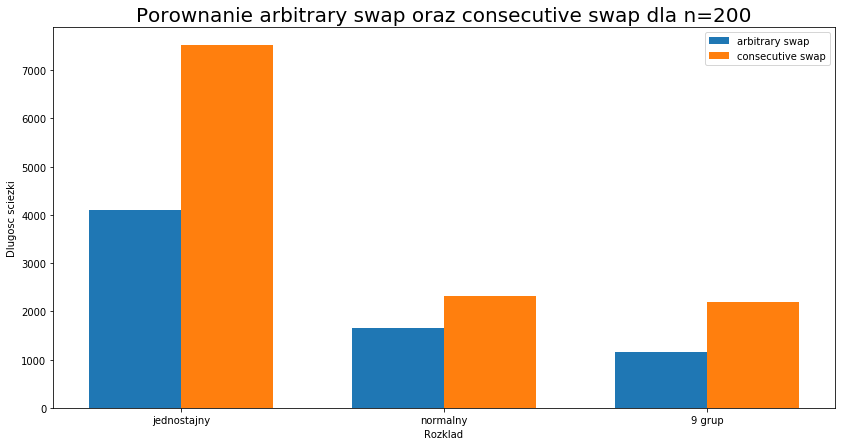

In [247]:
labels = ['jednostajny', 'normalny', '9 grup']

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, arbitrary, width, label='arbitrary swap')
ax.bar(x + width/2, consecutive, width, label='consecutive swap')

ax.set_ylabel('Dlugosc sciezki')
ax.set_xlabel('Rozklad')
ax.set_title('Porownanie arbitrary swap oraz consecutive swap dla n=200', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

Widać wyraźnie, że *arbitrary swap* daje lepsze rezultaty od *consecutive swap* dla każdego rodzaju rozkładu chmury punktów.

Teraz sprawdzimy jaki wpływ na rezultat końcowy ma temperatura i stała wyżarzania. Tym razem naszym zbiorem testowym będzie rozkład jednostajny dla $n = 100$.

In [248]:
n = 100
points = np.random.uniform(0, 100, size=(n, 2))
G = Graph(points)

In [249]:
T = np.arange(100, 2000, 400)
cool_rate_sm = []
cool_rate_md = []
cool_rate_lg = []

In [250]:
for t in T:
    G.best_points = points
    G.dual_annealing(t, 0.003)
    cool_rate_sm.append(G.get_distance(G.best_points))
    
    G.best_points = points
    G.dual_annealing(t, 0.005)
    cool_rate_md.append(G.get_distance(G.best_points))
    
    G.best_points = points
    G.dual_annealing(t, 0.01)
    cool_rate_lg.append(G.get_distance(G.best_points))

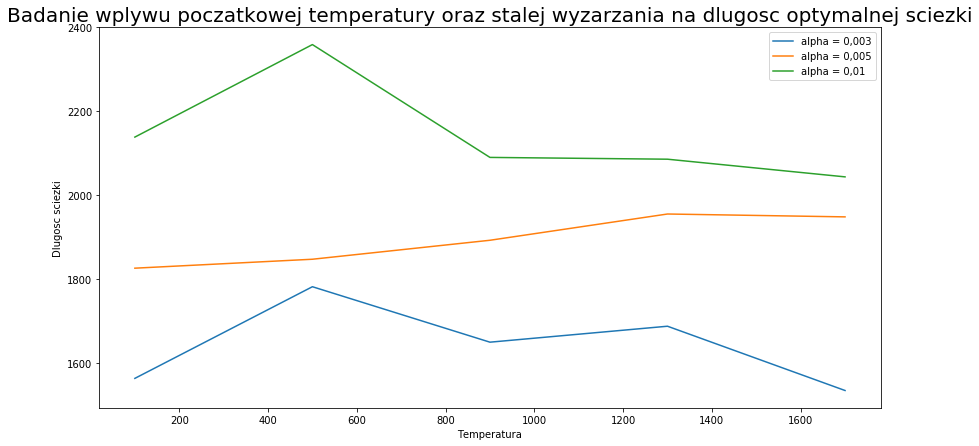

In [252]:
fig, ax = plt.subplots()

ax.plot(T, np.array(cool_rate_sm), label="alpha = 0,003")
ax.plot(T, np.array(cool_rate_md), label="alpha = 0,005")
ax.plot(T, np.array(cool_rate_lg), label="alpha = 0,01")

ax.set_ylabel('Dlugosc sciezki')
ax.set_xlabel('Temperatura')

ax.set_title('Badanie wplywu poczatkowej temperatury oraz stalej wyzarzania na dlugosc optymalnej sciezki', fontsize=20)
ax.legend()

plt.show()


Z wykresu możemy zaobserwować, że:
- dla stałej wyżarzania = 0,01, im wyższa początkowa temperatura tym raczej gorszy wynik końcowy. Oznaczałoby to, że parametry początkowe są źle dobrane.
- dla stałej wyżarzania = 0,005 oraz 0,003, im wyższa temperatura początkowa tym lepszy wynik końcowy. Najlepszy rezultat udało nam się uzyskać dla $alpha = 0,003$ oraz $T_p = 1700$

Spróbujmy teraz zwizualizować nasz najlepszy uzyskany rezultat

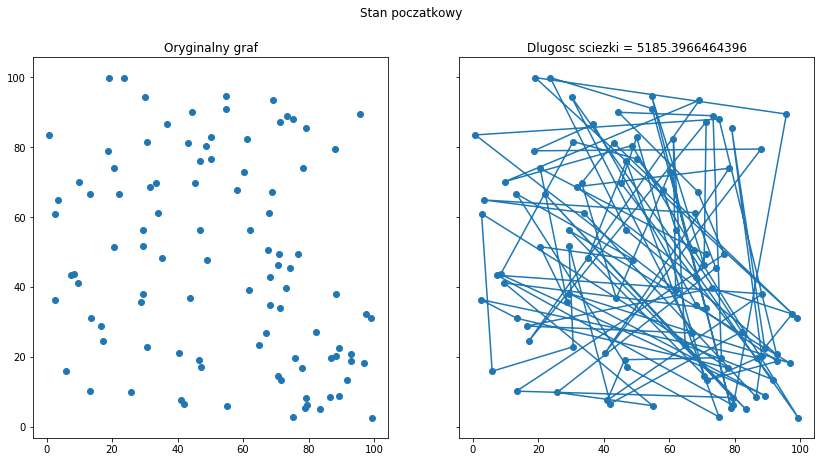

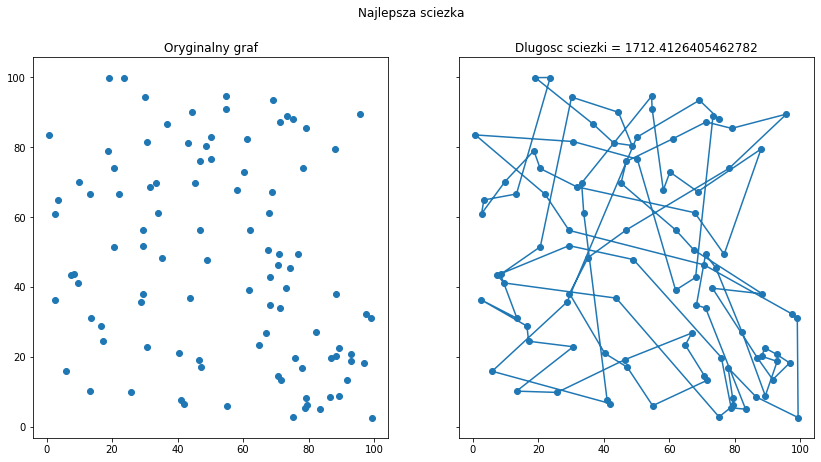

In [253]:
G = Graph(points)
G.dual_annealing(1700, 0.003)
G.plot_graph()
G.plot_best_path()

Udało nam się około 3-krotnie zmniejszyć długość ścieżki.

---
c) Przedstaw wizualizację działania procedury minimalizującej funkcję celu (funkcja przekazana do metody dual annealing może modyfikować zewnątrzny stan)